# Progetto Università: Analisi, Visualizzazione e Modello di Predizione

**Obiettivo di questo Notebook (Punti 7, 8 e 9):**
Questo notebook prosegue il lavoro iniziato nel file Spark (`01_Data_Processing_Spark`).

1.  **Punto 7:** Caricare i dati puliti (sia aggregati che campionati) ed eseguire un'analisi approfondita con Python Pandas.
2.  **Punto 8:** Creare visualizzazioni significative per comunicare le scoperte fatte sui dati.
3.  **Punto 9:** Costruire, addestrare e valutare un modello di Machine Learning per predire il tempo di percorrenza (`trip_duration_sec`).

## 📦 Blocco 0: Setup e Caricamento Dati

In questa fase, importiamo le librerie necessarie per l'analisi (Pandas, Seaborn) e il machine learning (Scikit-learn).

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive

# Import per il Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, median_absolute_error

# Stile per i grafici
sns.set_style("whitegrid")

# Google Drive per accedere ai file creati da Spark
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# --- Caricamento dei Dataset da Spark ---

PROJECT_PATH = "/content/drive/My Drive/Progetto-Taxi-NYC/"

# 1. Carichiamo il CAMPIONE PER IL ML (Punto 6 del notebook Spark)
# Questo è il dataset pulito, non aggregato, su cui addestreremo il modello
file_path_ml = f"{PROJECT_PATH}dati_taxi_puliti_per_ml.parquet"
df_ml = pd.read_parquet(file_path_ml)

# 2. Carichiamo i DATI AGGREGATI (Punto 5 del notebook Spark)
# Questi dati ci servono per l'analisi e la visualizzazione ad alto livello
file_path_agg = f"{PROJECT_PATH}dati_taxi_aggregati.parquet"
df_agg = pd.read_parquet(file_path_agg)

print(f"Caricate {len(df_ml)} righe per il training del modello.")
print(f"Caricate {len(df_agg)} righe di dati aggregati per l'analisi.")

Caricate 7093651 righe per il training del modello.
Caricate 24 righe di dati aggregati per l'analisi.


## Blocco 1: Analisi e Visualizzazione Dati (Punti 7 e 8)

Usiamo i due dataset creati per esplorare i dati e rispondere a domande chiave.

### 1.1 Analisi Dati Aggregati (Output del Punto 5)

Iniziamo analizzando i dati aggregati (media per ora) estratti da Spark. Questo ci dà una visione d'insieme del comportamento delle corse durante il giorno.

Dati Aggregati (Punto 5):
    pickup_hour  avg_duration_sec  avg_distance  trip_count
0             0        935.314503      4.013438      949618
1             1        856.759636      3.470988      619451
2             2        795.525886      3.113097      403055
3             3        793.319558      3.398946      257584
4             4        926.449908      5.023821      164727
5             5       1076.268269      6.404024      193992
6             6       1070.641187      4.972145      455878
7             7        992.575213      3.759816      922928
8             8       1001.207048      3.236097     1296518
9             9       1016.468233      3.144309     1502270
10           10       1052.256061      3.168066     1657214
11           11       1086.218349      3.142982     1799149
12           12       1116.097331      3.234930     1952008
13           13       1157.841943      3.428004     2023629
14           14       1225.889707      3.585846     2172567
15           1

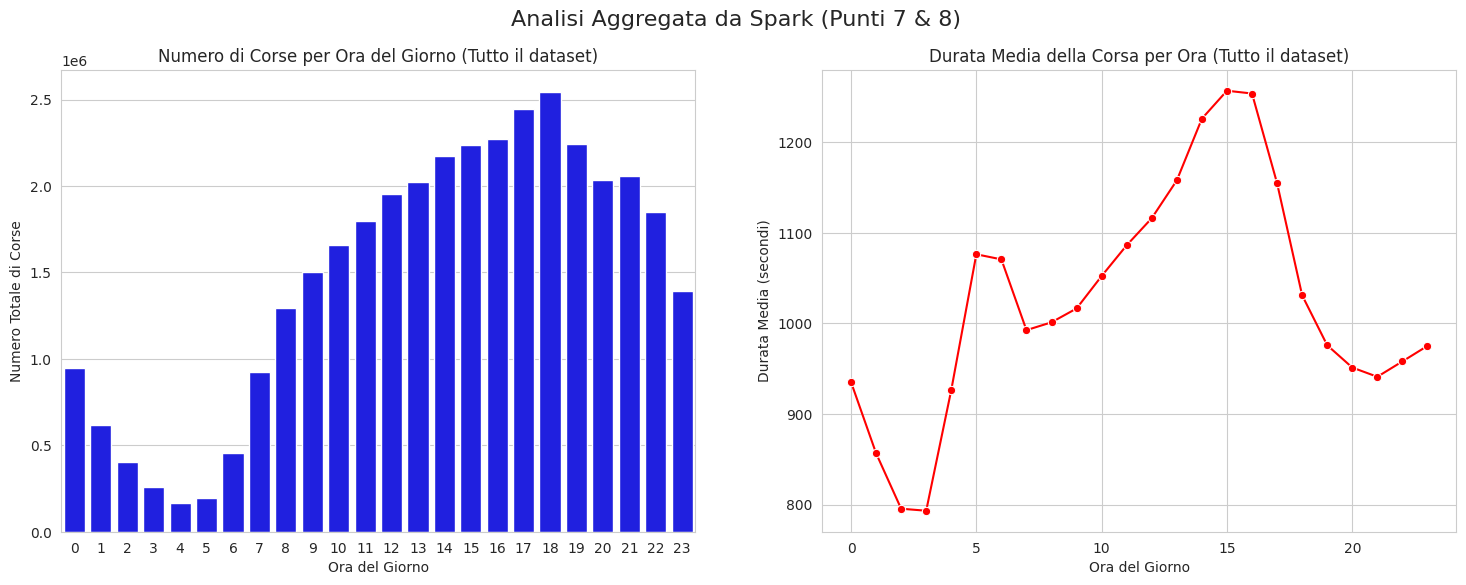

In [ ]:
# --- Punto 7 e 8: Analisi Dati Aggregati ---

print("Dati Aggregati (Punto 5):")
print(df_agg)

# Due grafici affiancati
plt.figure(figsize=(18, 6))

# Grafico 1: Numero di corse per ora
plt.subplot(1, 2, 1)
sns.barplot(x='pickup_hour', y='trip_count', data=df_agg, color='blue')
plt.title('Numero di Corse per Ora del Giorno (Tutto il dataset)')
plt.xlabel('Ora del Giorno')
plt.ylabel('Numero Totale di Corse')

# Grafico 2: Durata media per ora
plt.subplot(1, 2, 2)
sns.lineplot(x='pickup_hour', y='avg_duration_sec', data=df_agg, color='red', marker='o')
plt.title('Durata Media della Corsa per Ora (Tutto il dataset)')
plt.xlabel('Ora del Giorno')
plt.ylabel('Durata Media (secondi)')

plt.suptitle('Analisi Aggregata da Spark (Punti 7 & 8)', fontsize=16)
plt.show()

# - I grafici mostrano chiaramente le ore di punta (rush hour).
# - Il numero di corse (Grafico 1) ha un picco nel pomeriggio/sera.
# - La durata media (Grafico 2) ha due picchi: uno la mattina e uno il pomeriggio, corrispondenti al traffico mattutino e serale.

### 1.2 Analisi Campione per ML (EDA per Punto 9)

Ora esploriamo il campione `df_ml` per preparare il nostro modello. L'obiettivo è capire la distribuzione della nostra variabile target e le relazioni tra le feature.

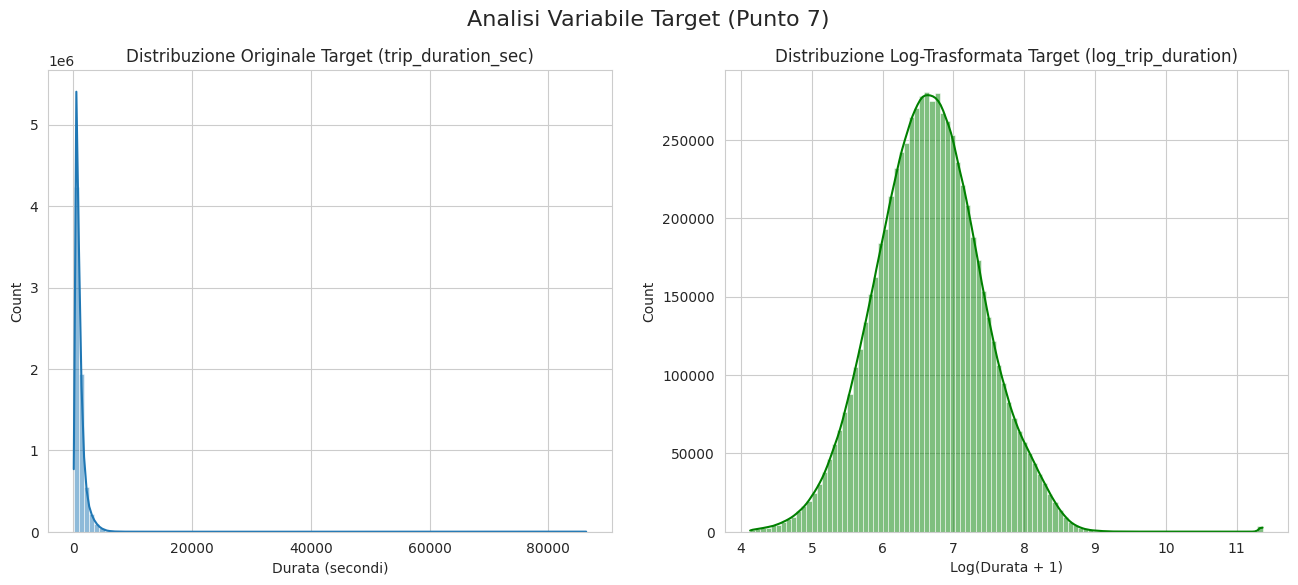

In [ ]:
# --- Punto 7: Analisi della Variabile Target ---

# La durata è asimmetrica.
# I modelli di regressione lineare funzionano male con target asimmetrici.
# Soluzione: usiamo una trasformazione logaritmica (log(x+1)).

df_ml['log_trip_duration'] = np.log1p(df_ml['trip_duration_sec'])

plt.figure(figsize=(16, 6))

# Grafico 1: Distribuzione Originale
plt.subplot(1, 2, 1)
sns.histplot(df_ml['trip_duration_sec'], bins=100, kde=True)
plt.title('Distribuzione Originale Target (trip_duration_sec)')
plt.xlabel('Durata (secondi)')

# Grafico 2: Distribuzione Log-Trasformata
plt.subplot(1, 2, 2)
sns.histplot(df_ml['log_trip_duration'], bins=100, kde=True, color='green')
plt.title('Distribuzione Log-Trasformata Target (log_trip_duration)')
plt.xlabel('Log(Durata + 1)')

plt.suptitle('Analisi Variabile Target (Punto 7)', fontsize=16)
plt.show()

# - Il grafico di sinistra (originale) è inutilizzabile per un modello.
# - Il grafico di destra (log-trasformato) ha una distribuzione quasi gaussiana, perfetta per il nostro modello di regressione.

In [ ]:
# --- Punto 7: Analisi Correlazioni ---

# Calcoliamo le correlazioni con il nostro NUOVO target log-trasformato
correlation_matrix = df_ml.corr(numeric_only=True)
correlation_target = correlation_matrix['log_trip_duration'].sort_values(ascending=False)

print("Correlazione delle feature con 'log_trip_duration':")
print(correlation_target)

# - 'trip_distance' e 'fare_amount' sono le feature numeriche più correlate.
# - 'PULocationID', 'pickup_hour', ecc. hanno correlazione quasi zero.

Correlazione delle feature con 'log_trip_duration':
log_trip_duration    1.000000
fare_amount          0.748186
trip_distance        0.676017
trip_duration_sec    0.489058
pickup_month         0.058183
passenger_count      0.039708
pickup_hour          0.031788
pickup_dayofweek     0.005571
payment_type        -0.019919
DOLocationID        -0.105621
PULocationID        -0.122236
Name: log_trip_duration, dtype: float64


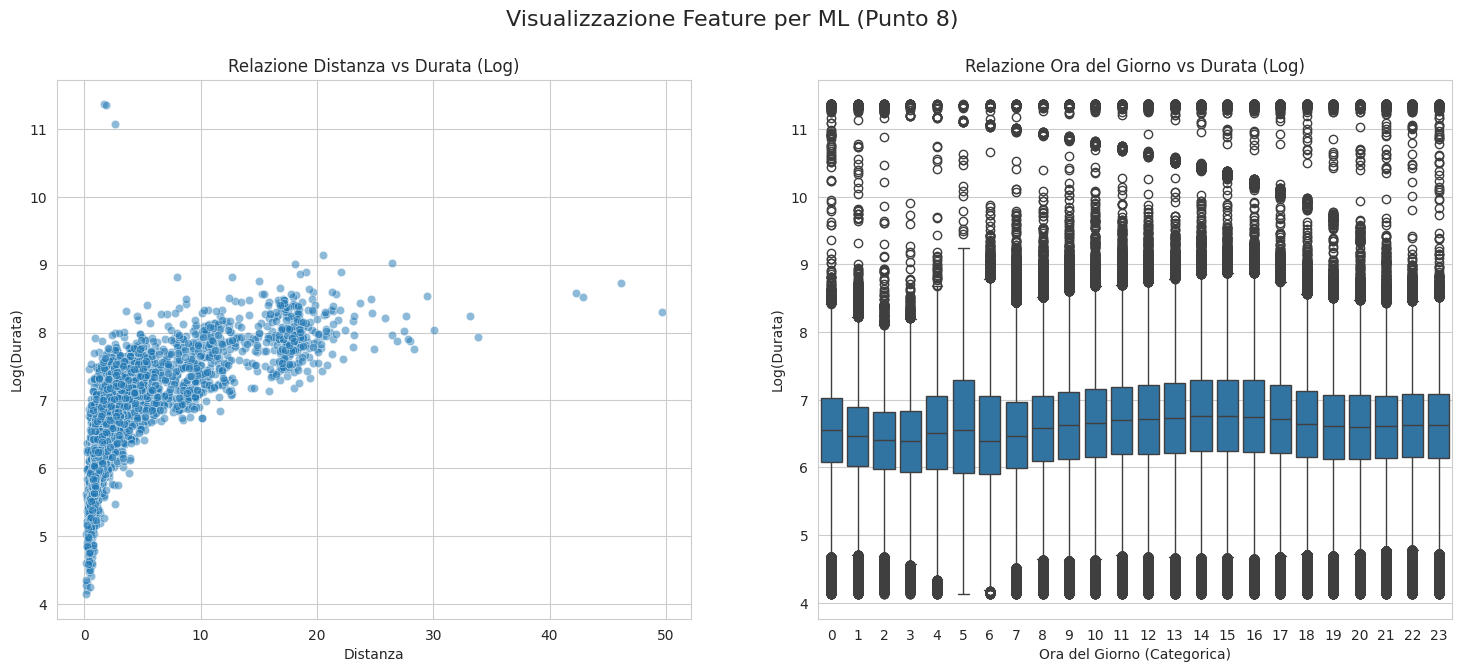

In [ ]:
# --- Punto 8: Visualizzazione Feature Chiave ---

plt.figure(figsize=(18, 7))

# Grafico 1: Distanza vs Durata (Scatter Plot)
plt.subplot(1, 2, 1)
# Usiamo un campione (sample) per non appesantire il grafico
sns.scatterplot(x='trip_distance', y='log_trip_duration', data=df_ml.sample(5000), alpha=0.5)
plt.title('Relazione Distanza vs Durata (Log)')
plt.xlabel('Distanza')
plt.ylabel('Log(Durata)')

# Grafico 2: Ora del Giorno vs Durata (Box Plot)
plt.subplot(1, 2, 2)
sns.boxplot(x='pickup_hour', y='log_trip_duration', data=df_ml)
plt.title('Relazione Ora del Giorno vs Durata (Log)')
plt.xlabel('Ora del Giorno (Categorica)')
plt.ylabel('Log(Durata)')

plt.suptitle('Visualizzazione Feature per ML (Punto 8)', fontsize=16)
plt.show()

# - Grafico 1: Mostra una forte relazione lineare positiva. La distanza sarà la nostra feature più importante.
# - Grafico 2: Conferma l'analisi aggregata. La durata media (la linea centrale del box) varia significativamente in base all'ora, con picchi nelle ore di punta (mattina e sera).
# - Questo giustifica l'uso di 'pickup_hour' come feature categorica.

## 🤖 Blocco 2: Modello di Machine Learning (Punto 9)

Siamo pronti per costruire il modello. Useremo un `ColumnTransformer` per applicare trasformazioni diverse alle feature numeriche (scaling) e categoriche (one-hot encoding), il tutto gestito da una `Pipeline`.

In [ ]:
# --- Punto 9 (Fase 1): Preparazione Dati ---

# Definiamo le nostre Feature (X) e il nostro Target (y)
y = df_ml['log_trip_duration']

# Le Feature (X) sono tutte le colonne selezionate tranne le nostre due colonne target
X = df_ml.drop(['trip_duration_sec', 'log_trip_duration'], axis=1)

# Dividiamo i dati in set di addestramento (train) e di test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Dimensioni X_train: {X_train.shape}")
print(f"Dimensioni X_test: {X_test.shape}")

Dimensioni X_train: (5674920, 9)
Dimensioni X_test: (1418731, 9)


In [ ]:
# --- Punto 9 (Fase 2): Creazione Preprocessing Pipeline ---

# Sulla base della nostra analisi (Punto 7/8), dividiamo le colonne in due gruppi:

# 1. Feature Numeriche: le scaleremo (StandardScaler)
numeric_features = ['trip_distance', 'passenger_count', 'fare_amount']

# 2. Feature Categoriche: le trasformeremo (OneHotEncoder)
categorical_features = ['PULocationID', 'DOLocationID', 'payment_type',
                        'pickup_hour', 'pickup_dayofweek', 'pickup_month']

# Creiamo il ColumnTransformer
# Questo oggetto applica le trasformazioni corrette alle colonne corrette
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

In [ ]:
# --- Punto 9 (Fase 3): Addestramento Modello ---

# Scegliamo un modello -> Regressione Lineare
model = LinearRegression()

# Creiamo la Pipeline completa
# 1. Applica il 'preprocessor' (scaling e encoding)
# 2. Passa i dati trasformati al 'model' (LinearRegression)
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', model)])

# Addestriamo la pipeline sui dati di training
print("Inizio addestramento del modello...")
pipeline.fit(X_train, y_train)
print("Modello addestrato!")

Inizio addestramento del modello...
Modello addestrato!


In [ ]:
# --- Punto 9 (Fase 4): Valutazione Modello ---

# Eseguiamo le predizioni sul set di test
y_pred_log = pipeline.predict(X_test)

y_pred_sec = np.expm1(y_pred_log)
y_test_sec = np.expm1(y_test)

# Calcoliamo le metriche di errore
med_ae = median_absolute_error(y_test_sec, y_pred_sec)

print("\n--- Risultati della Valutazione  ---")
print(f"Errore Mediano Assoluto: {med_ae:.2f} secondi")

# --- Valutazione Modello su Scala Logaritmica ---

# Calcoliamo le metriche di errore direttamente sui valori logaritmici
rmse_log = np.sqrt(mean_squared_error(y_test, y_pred_log))
mae_log = mean_absolute_error(y_test, y_pred_log)

print("\n--- Risultati della Valutazione (Scala Logaritmica) ---")
print(f"RMSE (Scala Logaritmica): {rmse_log:.4f}")
print(f"MAE (Scala Logaritmica):      {mae_log:.4f}")

# 1. VALIDAZIONE MATEMATICA (Scala Log):
#    - RMSE (0.43) e MAE (0.29) sono contenuti. Questo conferma che il modello ha appreso bene i pattern dai dati log-trasformati senza underfitting.

# 2. VALIDAZIONE PRATICA (Secondi):
#    - L'errore mediano è di 168.9 secondi (~2.8 minuti).
#    - Il modello è in grado di stimare la durata della corsa con uno scarto inferiore ai 3 minuti nella maggior parte dei casi.


--- Risultati della Valutazione  ---
Errore Mediano Assoluto: 168.92 secondi

--- Risultati della Valutazione (Scala Logaritmica) ---
RMSE (Scala Logaritmica): 0.4357
MAE (Scala Logaritmica):      0.2937


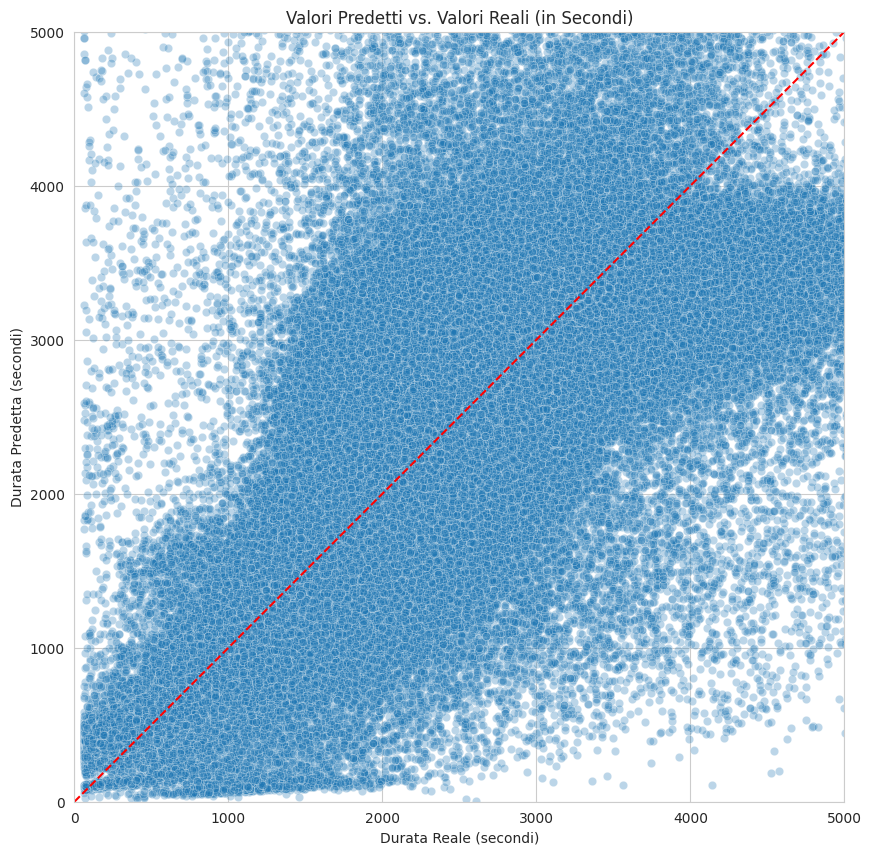

In [ ]:
# --- Punto 8 (Opzionale): Visualizzazione dei Risultati del Modello ---

plt.figure(figsize=(10, 10))
sns.scatterplot(x=y_test_sec, y=y_pred_sec, alpha=0.3)

# Aggiungiamo una linea a 45 gradi (y=x).
# Se il modello fosse perfetto, tutti i punti cadrebbero su questa linea.
lim_min = min(y_test_sec.min(), y_pred_sec.min())
lim_max = max(y_test_sec.max(), y_pred_sec.max())
# Prendiamo un limite ragionevole per evitare che gli outlier rovinino il grafico
plot_lim = min(lim_max, 5000) # Limite a ~80 minuti

plt.plot([0, plot_lim], [0, plot_lim], 'r--')
plt.xlim(0, plot_lim)
plt.ylim(0, plot_lim)
plt.title('Valori Predetti vs. Valori Reali (in Secondi)')
plt.xlabel('Durata Reale (secondi)')
plt.ylabel('Durata Predetta (secondi)')
plt.gca().set_aspect('equal', adjustable='box')
plt.show()